In [1]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import mpmath

In [3]:
%load_ext autoreload
%autoreload 2

In [99]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [100]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05)#np.ones((4,4))*(0.05) ou number_of_pop*0.05
delays=np.zeros((4,4))*(0.05)
#p_con[2][2]=0.6 #inh tres connecté p_con[0][3]=p_con[1][2]=p_con[2][3]=p_con[3][2]=0
p_con[3][0]=p_con[2][1]=p_con[2][3]=p_con[3][2]=0 ## the two FS populations are not connected !
p_pois=np.ones(4)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[1e-12,1e-12,0,0] # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-70e-3,-70e-3,-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=4.5e-9 # Qe à 2e-9 par vers 200Hz
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]


params['delays']=delays

params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8,0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [1, 1, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [1e-12, 1e-12, 0, 0], 'El': [-0.07, -0.07, -0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 4.5e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.05, -0.05], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'delays': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7fab3a176af0>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05],
       [0.05, 0.  , 0.05, 0.  ],
       [0.  , 0.05, 0.  , 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [101]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'
#NRN3='RS-cell'
#NRN4='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp_2 = load_transfer_functions_with_ALL_params_ij(NRN1, NRN2, NTWK,par,1,3)
 # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


### Integration of the MF equations with delays

##### Straight to second order !

In [27]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5
#x0=np.ones([params['numb_var'],]*1e-5 )
x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.72 #ve2 exp ajout 20%
x0[2]=7.0 #vi1 exp 
x0[3]=8.4 #vi2 exp  ajout 20%
x0[20]=x0[0]*1e-12 #x0[0]*60e-12 ici point fixe pour la stabilité
x0[21]=x0[1]*1e-12 #w exp

print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]


x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()

#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.0e-01 7.2e-01 7.0e+00 8.4e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 6.0e-13 7.2e-13]
[6.0e-01 7.2e-01 7.0e+00 8.4e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 6.0e-13 7.2e-13]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [28]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[ 1.15483649e-02  1.15473489e-02  1.40857950e+01  1.40857882e+01
  1.46805258e-04  7.61286608e-06  6.56850084e-04 -1.01411146e-04
  7.61286608e-06  1.46791747e-04 -1.01398263e-04  6.56788473e-04
  6.56850084e-04 -1.01398263e-04  1.52661943e-01 -4.19684581e-04
 -1.01411146e-04  6.56788473e-04 -4.19684581e-04  1.52661479e-01
  1.95184221e-13  2.11370222e-13]


In [18]:
np.save('x_trace_b1_1.5.npy',x_trace_RS)
np.save('t_trace_b1_1.5.npy',t_trace)

In [15]:
x=np.load('x_trace_b1_1.5.npy')
t=np.load('t_trace_b1_1.5.npy')

In [102]:
final_state = np.array([ 1.57383566e-03, 1.57307464e-03, 6.79409895e+00, 2.19638848e+00, 
                        5.19015082e-06, 9.94248010e-08, 3.44307533e-05, -2.20898068e-04,
                        9.94248010e-08, 5.19004643e-06, 2.65331631e-05, -2.18150887e-04,
                        3.44307533e-05, 2.65331631e-05, 1.80949196e-01, 3.55410840e-02,
                        -2.20898068e-04, -2.18150887e-04, 3.55410840e-02, 1.84432211e+00,
                        8.47070670e-14, 1.01023097e-13])

In [67]:
final_state_euler=np.array([ 1.15554287e-02, 1.15544048e-02, 1.40858422e+01, 1.40858354e+01,
                            1.46899312e-04, 7.62209490e-06, 6.57278811e-04, -1.01444218e-04,
                            7.62209490e-06, 1.46885690e-04, -1.01431211e-04, 6.57216684e-04,
                            6.57278811e-04, -1.01431211e-04, 1.52665178e-01, -4.19904179e-04,
                            -1.01444218e-04, 6.57216684e-04, -4.19904179e-04,1.52664710e-01,
                            9.03401345e-14,1.06648539e-13])

In [16]:
x_transp=np.transpose(x)
#TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

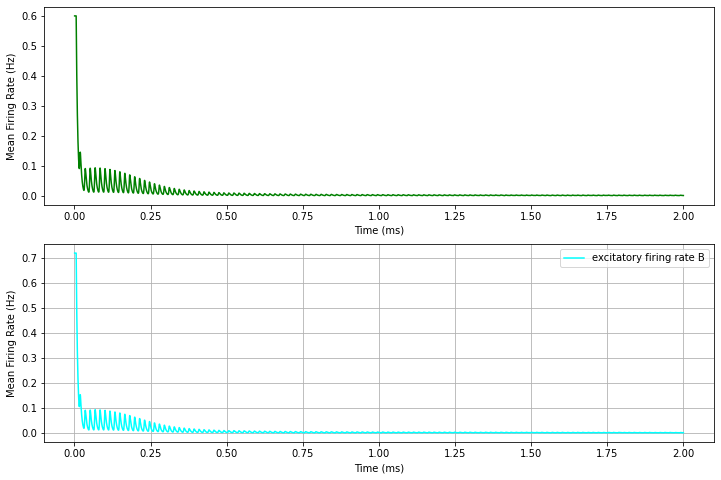

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t, ve1[0:4000], color="green", label="excitatory firing rate A")
#axs[0].plot(t_trace, vi1[steps+1:], color="red", label="inhibitory firing rate A")
axs[1].plot(t, ve2[0:4000], color="cyan", label="excitatory firing rate B")
#axs[1].plot(t_trace, vi2[steps+1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

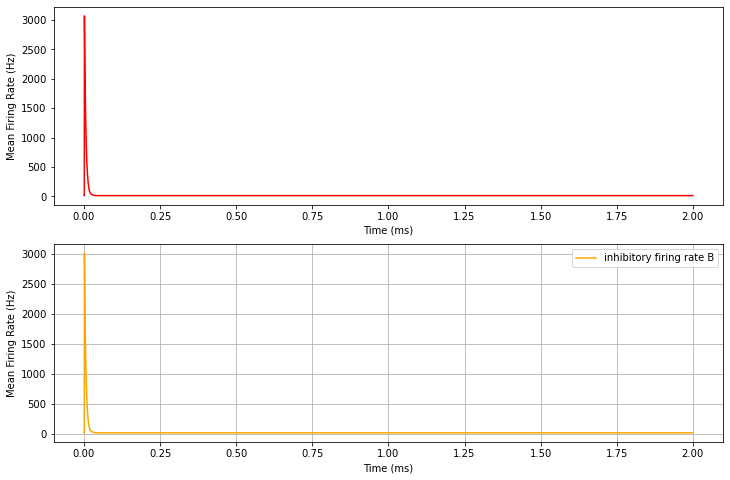

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
#axs[0].plot(t_trace, ve1[steps+1:], color="green", label="excitatory firing rate A")
axs[0].plot(t_trace, vi1[steps+1:], color="red", label="inhibitory firing rate A")
#axs[1].plot(t_trace, ve2[steps+1:], color="cyan", label="excitatory firing rate B")
axs[1].plot(t_trace, vi2[steps+1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

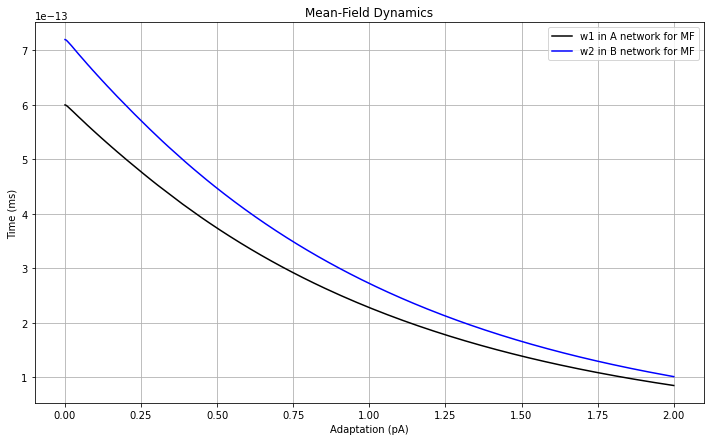

In [59]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace,w1[steps+1:],color="black",label="w1 in A network for MF")
plt.plot(t_trace,w2[steps+1:],color="blue",label="w2 in B network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")

plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

In [32]:
delays=np.zeros((4,4))
#delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]
#delays[0][3]=delays[1][2]=0.001 #proche  #delays[0][1]=delays[1][0]
delays[0][1]=delays[0][3]=delays[1][0]=delays[1][2]=0.005 #delai colonne distantes entre exc-inh et exc-exc colonnes diff
#print(delays)

In [33]:
np.random.seed(10)
x0=final_state.copy()
#x0[0]+=0.5
#x0[1]+=0.5
#x0[2]+=0.5
#x0[3]+=0.5
print(x0)
#time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

[ 1.15483649e-02  1.15473489e-02  1.40857950e+01  1.40857882e+01
  1.46805258e-04  7.61286608e-06  6.56850084e-04 -1.01411146e-04
  7.61286608e-06  1.46791747e-04 -1.01398263e-04  6.56788473e-04
  6.56850084e-04 -1.01398263e-04  1.52661943e-01 -4.19684581e-04
 -1.01411146e-04  6.56788473e-04 -4.19684581e-04  1.52661479e-01
  1.95184221e-13  2.11370222e-13]
Max delay =  0.005
[ 1.15483649e-02  1.15473489e-02  1.40857950e+01  1.40857882e+01
  1.46805258e-04  7.61286608e-06  6.56850084e-04 -1.01411146e-04
  7.61286608e-06  1.46791747e-04 -1.01398263e-04  6.56788473e-04
  6.56850084e-04 -1.01398263e-04  1.52661943e-01 -4.19684581e-04
 -1.01411146e-04  6.56788473e-04 -4.19684581e-04  1.52661479e-01
  1.95184221e-13  2.11370222e-13]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [34]:
final_state1=x_trace_RS[-1]
print(final_state1)

[2.62184531e-03 2.62180339e-03 2.99675555e+01 8.30838782e+00
 3.53877209e-06 6.26385880e-07 8.67827350e-03 7.65481059e-04
 6.26385880e-07 3.53926955e-06 8.66693124e-03 7.72868149e-04
 8.67827350e-03 8.66693124e-03 1.07557529e+02 1.31584821e+01
 7.65481059e-04 7.72868149e-04 1.31584821e+01 1.57534784e+01
 2.98304408e-14 3.20197266e-14]


In [22]:
np.save('x_trace_b1_5ms.py',x_trace_RS)
np.save('TF_trace_b1_5ms.py',TF_trace_RS)

In [35]:
x_transp=np.transpose(x_trace_15)
#TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]
vi1=x_transp[2]
vi2=x_transp[3]#[1000:]
w1=x_transp[20]
w2=x_transp[21]

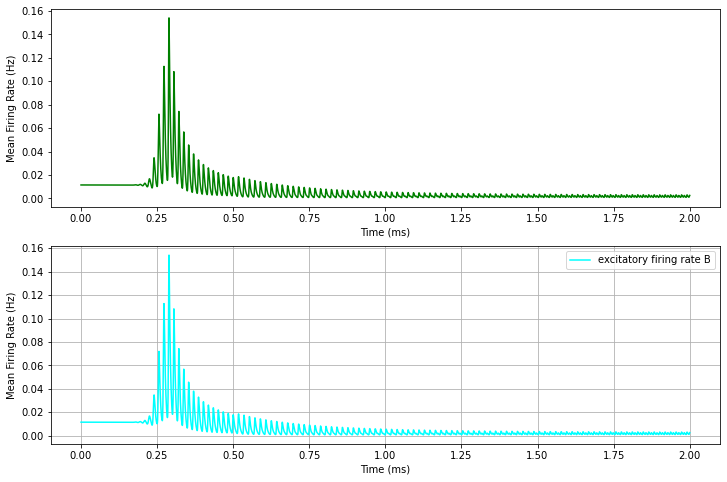

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t_trace, ve1[steps+1:], color="green", label="excitatory firing rate A")
#axs[0].plot(t_trace, vi1[steps+1:], color="red", label="inhibitory firing rate A")
axs[1].plot(t_trace, ve2[steps+1:], color="cyan", label="excitatory firing rate B")
#axs[1].plot(t_trace, vi2[steps+1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

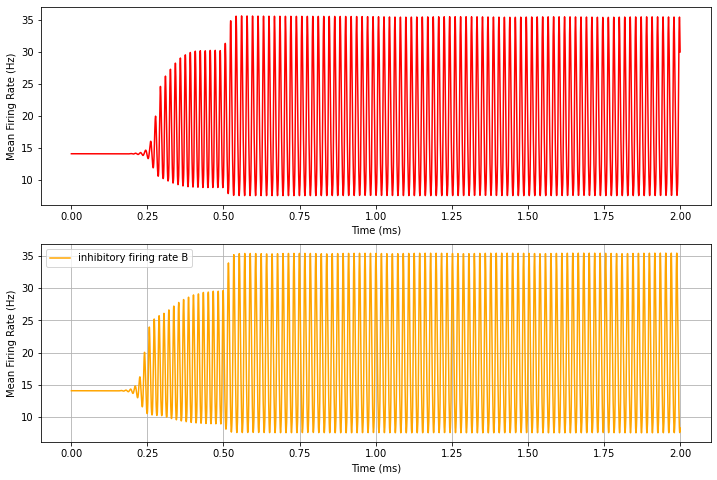

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
#axs[0].plot(t_trace, ve1[steps+1:], color="green", label="excitatory firing rate A")
axs[0].plot(t_trace, vi1[steps+1:], color="red", label="inhibitory firing rate A")
#axs[1].plot(t_trace, ve2[steps+1:], color="cyan", label="excitatory firing rate B")
axs[1].plot(t_trace, vi2[steps+1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

In [ ]:
mean_firing_rates_e1 = []
mean_firing_rates_e2 = [] 
mean_firing_rates_i1 = [] 
mean_firing_rates_i2 = [] 
mean_e1=0
std_e1=0
mean_e2=0
std_e2=0
mean_i1=0
std_i1=0
mean_i2=0
std_i2=0
delai=np.arange(1e-3,6e-3,1e-3)
qes=np.arange(1.6e-9,2.2e-9,7e-11)
for k, delay in enumerate(delai): 
    for n, qe in enumerate(qes): 

        ''' DEFINE THE INPUT FUNCTION '''
        par['qe'][0][1]=qe
        par['qe'][0][3]=qe
        par['qe'][1][0]=qe
        par['qe'][1][2]=qe
        par['delays'][0][1]=delay
        par['delays'][1][0]=delay
        par['delays'][1][2]=delay
        par['delays'][0][3]=delay

        x0=final_state.copy()
        t_trace=[]
        x_trace_RS=[]
        TF_trace_RS=[]
        x_trace_RS.append(x0.copy())
        
        std_e1+=x_trace_RS[0]**2
        mean_e1+=x_trace_RS[0]
        std_e2+=x_trace_RS[1]**2
        mean_2+=x_trace_RS[1]
        std_i1+=x_trace_RS[2]**2
        mean_i1+=x_trace_RS[2]
        std_i2+=x_trace_RS[3]**2
        mean_i2+=x_trace_RS[3]
        

#########INITIATE THE PAST COORDINATES ##################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()
        
#### Associated number of time steps: Delay line ##
        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())
##########################################################
        time=0
    
        for i in np.arange(0,5,params['tstep']):
            par['x_hist']=np.transpose(x_trace_RS)
            TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            t_trace.append(time)
            x_trace_RS.append(x0.copy())
            TF_trace_RS.append(TF_inst.copy())
        x_transp=np.transpose(x_trace_RS)
        std_e1+=std_e1/steps
        mean_e1+=np.sqrt(std_e1/(steps-mean_e1))
        std_e2+=std_e2/steps
        mean_e2+=np.sqrt(std_e2/(steps-mean_e2))
        std_i1+=std_i1/steps
        mean_i1+=np.sqrt(std_i1/(steps-mean_i1))
        std_e2+=std_i2/steps
        mean_e2+=np.sqrt(std_i2/(steps-mean_i2))
        
        mean_firing_rates_e1.append(x_transp[(k+n-1, x_transp.shape[0]-1), steps+1:])
        mean_firing_rates_e2.append(x_transp[(k+n, x_transp.shape[0]-1), steps+1:])
        mean_firing_rates_i1.append(x_transp[(k+n+1, x_transp.shape[0]-1), steps+1:])
        mean_firing_rates_i2.append(x_transp[(k+n+2, x_tranps.shape[0]-1), steps+1:])
        
        np.save('frE1_b1.npy',exciatory_firing_rates1)
        np.save('frE2_b1.npy',exciatory_firing_rates2)
        np.save('frI1_b1.npy',exciatory_firing_rates3)
        np.save('frI2_b1.npy',exciatory_firing_rates4)
        np.save('mean_e1_b1.npy',mean_e1)
        np.save('mean_e2_b1.npy',mean_e2)
        np.save('mean_i1_b1.npy',mean_i1)
        np.save('mean_i2_b1.npy',mean_i2)
        np.save('std_e1_b1.npy',std_e1)
        np.save('std_e2_b1.npy',std_e2)
        np.save('std_i1_b1.npy',std_i1)
        np.save('std_i2_b1.npy',std_i2)

In [107]:
mean_firing_rates_e1 = []
mean_firing_rates_e2 = [] 
mean_firing_rates_i1 = [] 
mean_firing_rates_i2 = [] 
for delay in np.arange(1e-3,6e-3,1e-3): #refaire np.linspace(5e-10,4.5e-9,5) #espacement de 1
    for qe in np.arange(1.5e-9,2.2e-9,7e-11): #1.5 a 2.2 7e-11

        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][1][2]=delay
        params['delays'][0][3]=delay

        x0=final_state.copy()
        #x0[0]+=0.5
        #x0[1]+=0.5
        t_trace=[]
        x_trace_RS=[]
        TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=0
    
        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            t_trace.append(time)
            x_trace_RS.append(x0.copy())
            TF_trace_RS.append(TF_inst.copy())
        x_transp=np.transpose(x_trace_RS)
        mean_firing_rates_e1.append(x_transp[0, steps+1:])
        mean_firing_rates_e2.append(x_transp[1, steps+1:])
        mean_firing_rates_i1.append(x_transp[2, steps+1:])
        mean_firing_rates_i2.append(x_transp[3, steps+1:])

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.7e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



ValueError: operands could not be broadcast together with shapes (0,) (4000,) 

In [4]:
frE1_euler=np.load('frE1_euler.npy')

In [3]:
frE2_euler=np.load('frE2_euler.npy')

In [ ]:
frI1_euler=np.load('frI1_euler.npy')

In [15]:
frI2_euler=np.load('frI2_euler.npy')

In [89]:
frE1_rk4=np.load('frE1_rk4.npy')

In [30]:
frE2_rk4=np.load('frE2_rk4.npy')

In [80]:
frI1_rk4=np.load('frI1_rk4.npy')

In [11]:
frI2_rk4=np.load('frI2_rk4.npy')

In [192]:
frI2=np.load('frI2.npy')

In [31]:
x_trace=np.load('x_trace_rk4.npy')

In [19]:
t_trace=np.load('t_trace_rk4.npy')

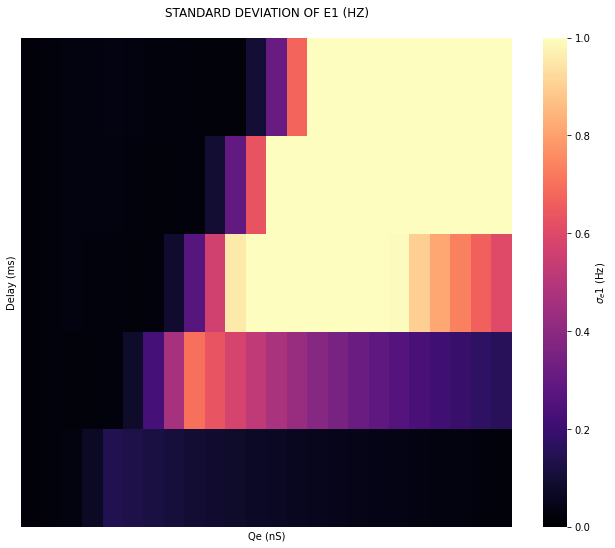

In [206]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(std_e1,vmin=0,vmax=1, cmap="magma",cbar_kws={'label': '$\\sigma_e1$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
title = 'Standard deviation of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

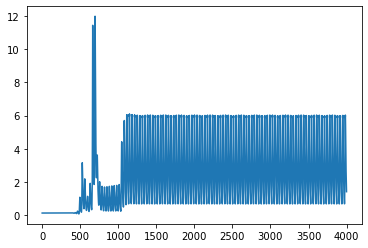

In [50]:
plt.plot(frE1_euler[49,:])

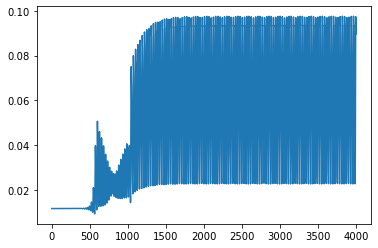

In [130]:
plt.plot(frE1_euler[39,:])

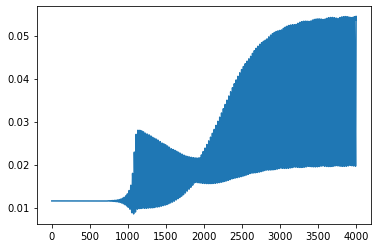

In [80]:
plt.plot(frE1_euler[29,:])

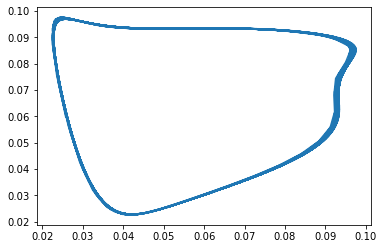

In [46]:
plt.plot(frE1_euler[39,1500:2500],frE1_euler[39,2500:3500])

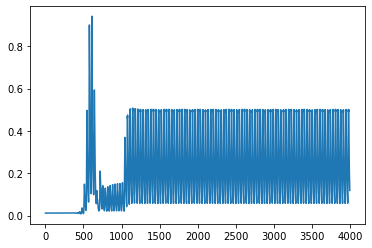

In [12]:

plt.plot(frE2_euler[49,:])

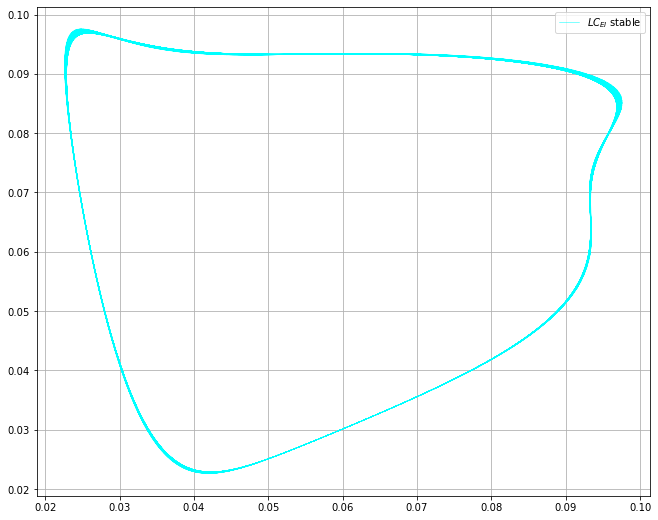

In [150]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE2_euler[39,2000:3000],frE2_euler[39,3000:4000], 'cyan', lw=0.5,label="$LC_{EI}$ stable")

#ax.set_xlabel("Time (ms)")
ax.grid(True)
#ax.set_ylabel("Firing rates (Hz)")
ax.legend()

#plt.xticks(np.linspace(400,1000))
#plt.plot(frE2_euler[39,1001:1501],frE2_euler[39,1502:2002])

No handles with labels found to put in legend.


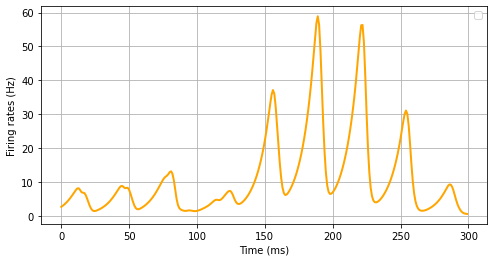

In [42]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE2_euler[49,500:800], 'orange' ,lw=2)

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()

#plt.plot(frE2_euler[49,500:800]*(50/0.8))

No handles with labels found to put in legend.


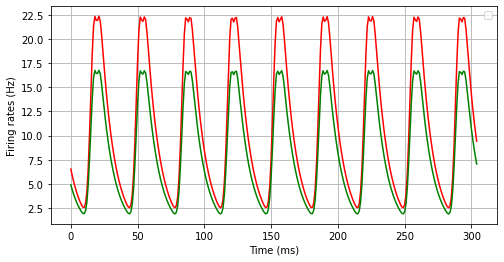

In [53]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE2_euler[49,1195:1500], 'red' )
ax.plot(frE2_euler[49,1195:1500], 'green' )

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()

No handles with labels found to put in legend.


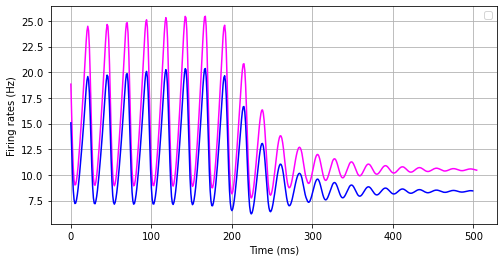

In [26]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[29,795:1300], 'magenta' )
ax.plot(frE1_euler[29,800:1300], 'blue' )

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()

No handles with labels found to put in legend.


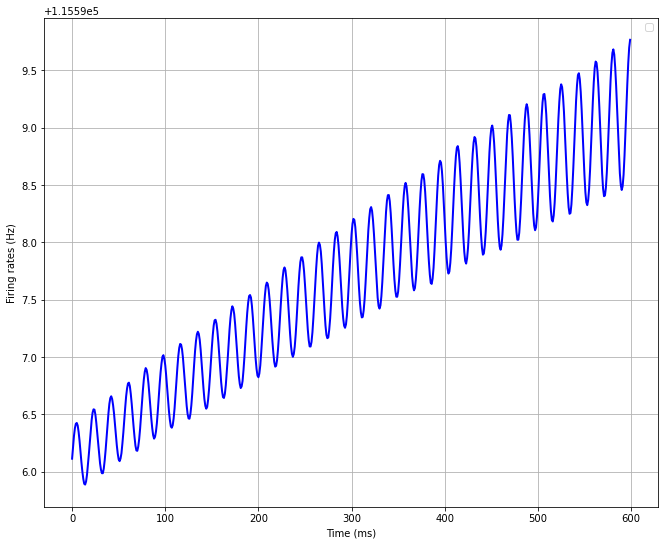

In [149]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE2_euler[19,3400:4000], 'b' ,lw=2)

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()

In [ ]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(FrE2_euler[49, 'lime', lw=2,label="$LC_{EA}$")

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()

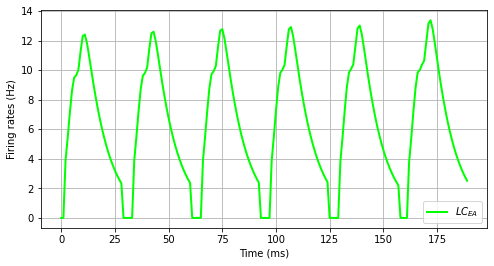

In [5]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(FrE1[39,, 'lime', lw=2,label="$LC_{EA}$")

ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_ylabel("Firing rates (Hz)")
ax.legend()


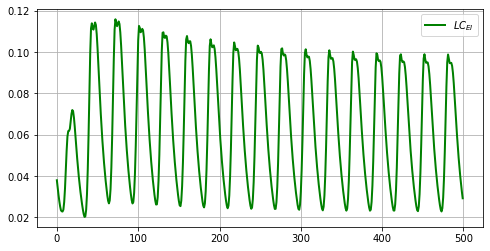

In [59]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE2_euler[39,1000:1500], 'g', lw=2,label="$LC_{EI}$")

#ax.set_xlabel("Time (ms)")
ax.grid(True)

#ax.set_ylabel("Firing rates (Hz)")
ax.legend()

No handles with labels found to put in legend.


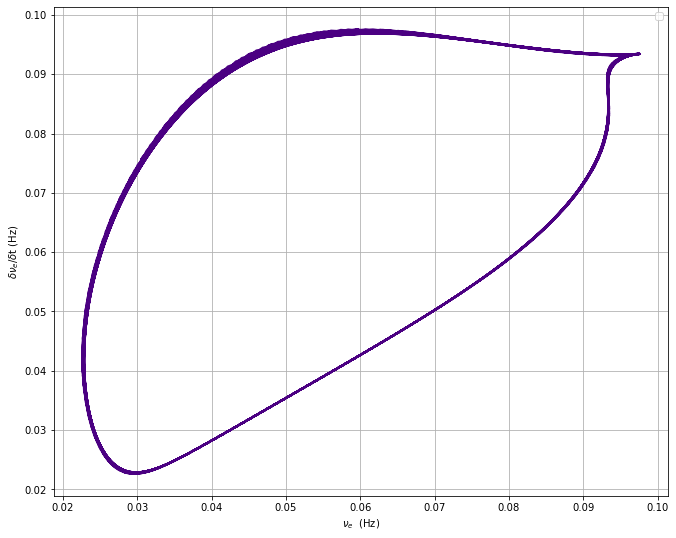

In [42]:
fig,ax=plt.subplots(figsize=(11, 9))


ax.plot(frE2_euler[39,2001:2501],frE2_euler[39,2501:3001], 'indigo', lw=2)
ax.set_ylabel("$\\delta$$\\nu_e$/$\\delta$t (Hz)")
ax.grid(True)

ax.set_xlabel("$\\nu_e$  (Hz)")
ax.legend()


No handles with labels found to put in legend.


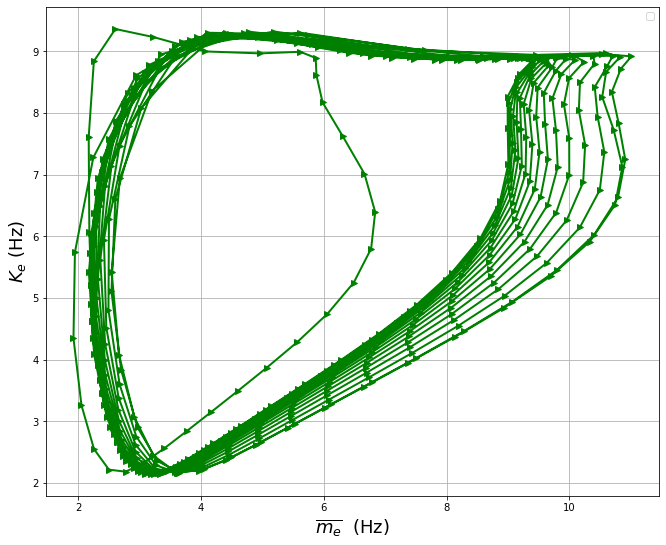

In [10]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE2_euler[39,1001:1501]),frE2_euler[39,1502:2002], 'g->', lw=2)

ax.set_ylabel("$K_e$ (Hz)",fontsize=18)
ax.grid(True)

ax.set_xlabel("$\\overline{m_e}$  (Hz)",fontsize=18)
ax.legend()
#plt.xticks(np.linspace(400,1000))
#plt.plot(frE2_euler[39,1001:1501],frE2_euler[39,1502:2002])

No handles with labels found to put in legend.


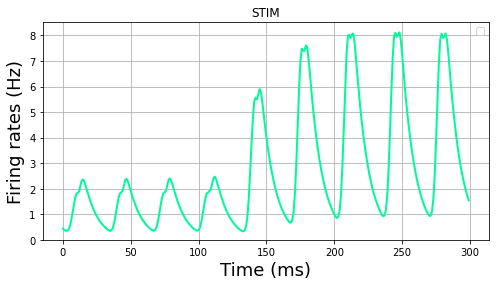

In [6]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[49,900:1200], 'mediumspringgreen', lw=2)

ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylim(bottom=0)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.set_title('STIM')
ax.legend()


No handles with labels found to put in legend.


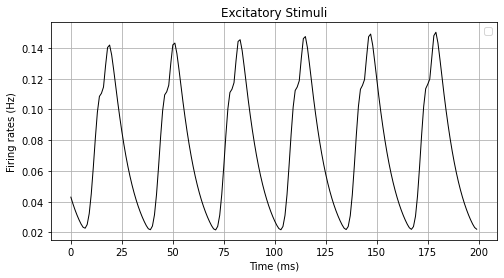

In [20]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[49,800:1000], 'k', lw=1)

ax.set_xlabel("Time (ms)")
ax.set_title("Excitatory Stimuli")
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()



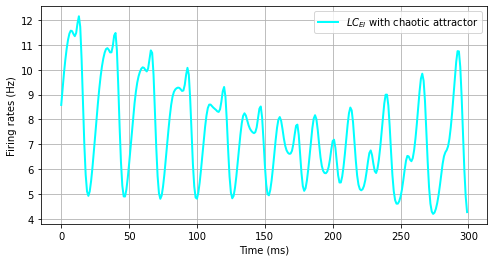

In [41]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[39,700:1000], 'cyan', lw=2,label="$LC_{EI}$ with chaotic attractor")

ax.set_xlabel("Time (ms)")
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()

#plt.xticks(np.linspace(400,1000))

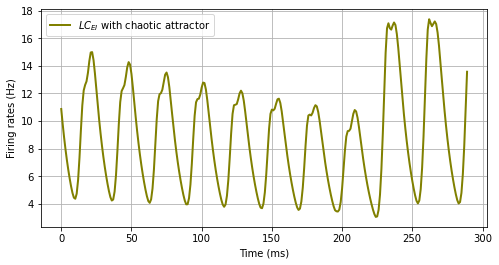

In [106]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE2_euler[39,810:1100], 'olive', lw=2,label="$LC_{EI}$ with chaotic attractor")

ax.set_xlabel("Time (ms)")
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()

#plt.xticks(np.linspace(400,1000))

In [4]:
Fre1_lcea=np.array([0.58094746, 0.64544136, 0.71708211, 0.79668544, 0.88514141,
       0.98342904, 1.09262774, 1.21392637, 1.34862644, 1.49810355,
       1.66360013, 1.84577677, 2.04404683, 2.25913305, 2.48948665,
       2.72750466, 2.94817548, 3.08701767, 3.03271242, 2.74200851,
       2.4523251 , 2.39274205, 2.31087303, 2.27249614, 2.02917256,
       1.65664676, 1.24134212, 0.86624512, 0., 0,
       0, 0, 0.50965028, 0.56535785, 0.6280464 ,
       0.69776317, 0.77519936, 0.86121813, 0.95677696, 1.0629163 ,
       1.18075332, 1.31146096, 1.45625469, 1.61633145, 1.79252153,
       1.98509491, 2.19398556, 2.41775226, 2.64930088, 2.86517255,
       3.004464  , 2.95989899, 2.68314184, 2.39590932, 2.32730184,
       2.27069499, 2.03608802, 1.66876482, 1.25554862, 0.87867293,
       0, 0 , 0, 0, 0 ,
       0.55962215, 0.62166035, 0.6906672 , 0.76731469, 0.85245588,
       0.94703913, 1.05209502, 1.16873013, 1.29810606, 1.44142484,
       1.59987415, 1.7742882 , 1.96492677, 2.17170605, 2.3932602 ,
       2.62285856, 2.83816545, 2.98086037, 2.94617892, 2.67967595,
       2.3888202 , 2.3134854 , 2.2627034 , 2.03669077, 1.67515642,
       1.26539004, 0.88852146, 0, 0., 0,
       0, 0, 0.5530235 , 0.61431287, 0.68250217,
       0.75824125, 0.84237133, 0.93583008, 1.03963624, 1.15488305,
       1.28271718, 1.42432247, 1.58086902, 1.75317941, 1.94148191,
       2.14564353, 2.36431725, 2.59102603, 2.80435664, 2.94838684,
       2.9214395 , 2.66519563, 2.3734728 , 2.29248133, 2.2465543 ,
       2.02860802, 1.67340292, 1.26884256, 0.8945537 , 0,
       0, 0  , 0, 0, 0.54603426,
       0.60652787, 0.67384982, 0.74862483, 0.83168117, 0.9239449 ,
       1.02642164, 1.14018914, 1.26637579, 1.40614257, 1.56063232,
       1.73063345, 1.91630594, 2.11741406, 2.33254364, 2.55529951,
       2.76486477, 2.9073536 , 2.88467819, 2.63754664, 2.34806818,
       2.26339708, 2.22104844, 2.0099446 , 1.66130757, 1.26409232,
       0.89588067, 0, 0, 0, 0 ,
       0, 0.54035982, 0.60019863, 0.66681309, 0.74080113,
       0.82297912, 0.91426336, 1.01564794, 1.12819579, 1.25301643,
       1.39124624, 1.54399139, 1.71197434, 1.89522552, 2.09331685,
       2.30462448, 2.52256216, 2.72638369, 2.86355657, 2.83992832,
       2.59896172, 2.31497347, 2.22974764, 2.18934553, 1.98270908,
       1.64006796, 1.25216274, 0.89404378, 0, 0])

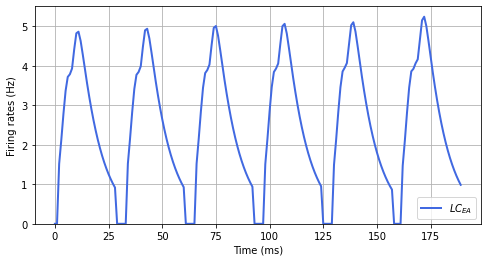

In [40]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(Fre1_lcea, 'royalblue', lw=2,label="$LC_{EA}$")

ax.set_xlabel("Time (ms)")
ax.grid(True)
ax.set_ylim(bottom=0)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()


No handles with labels found to put in legend.


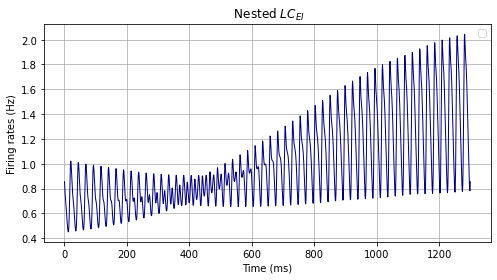

In [24]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[29,1500:2800], 'navy', lw=1)

ax.set_xlabel("Time (ms)")
ax.set_title(" Nested $LC_{EI}$")
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()



#plt.plot(frE1_euler[29,1900:2800]*(4/0.055))

No handles with labels found to put in legend.


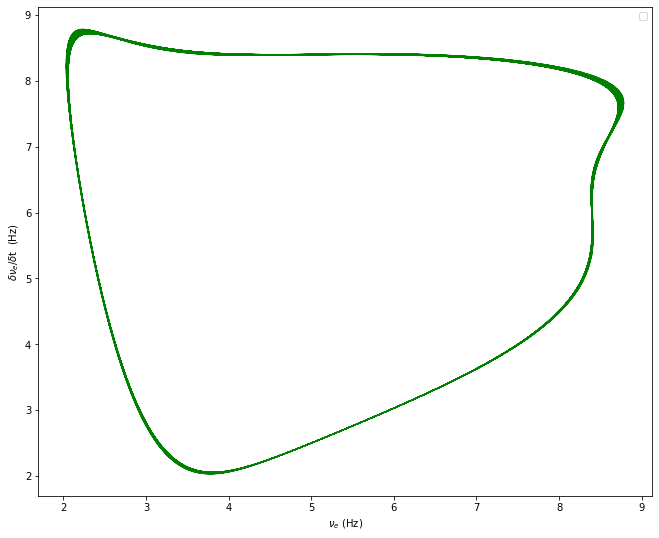

In [56]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE2_euler[39,2000:3000]*(9/0.1),frE2_euler[39,3000:4000]*(9/0.1),'green', lw=1)
#ax.plot(frE2_euler[39,2000:3000]*(11/0.1),frE2_euler[39,3000:4000]*(11/0.1),'r', lw=1)
ax.set_xlabel("$\\nu_e$ (Hz)")
#ax.grid(True)
ax.set_ylabel("$\\delta$$\\nu_e$/$\\delta$t  (Hz)")
ax.legend()

No handles with labels found to put in legend.


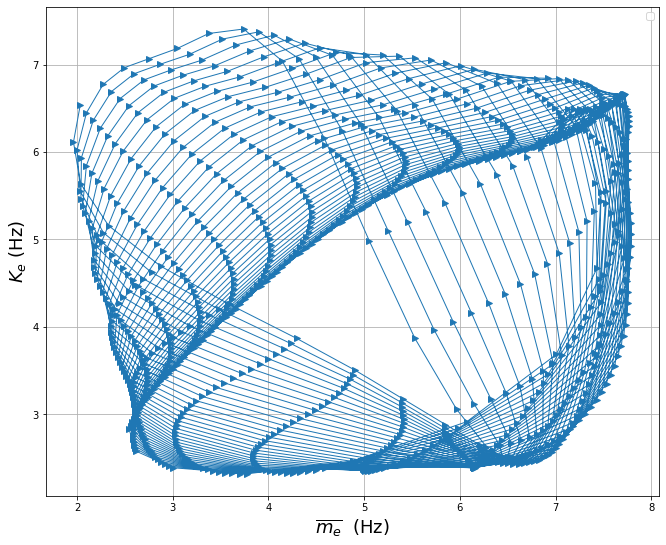

In [7]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE2_euler[29,1500:2500],frE2_euler[29,2500:3500],'->', lw=1)

ax.set_ylabel("$K_e$ (Hz)",fontsize=18)
ax.grid(True)

ax.set_xlabel("$\\overline{m_e}$  (Hz)",fontsize=18)
ax.legend()


No handles with labels found to put in legend.


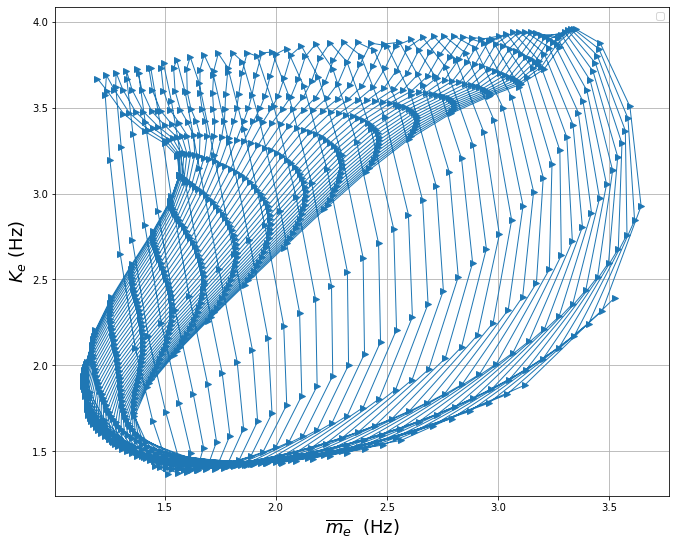

In [8]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE1_euler[29,1900:2900],frE1_euler[29,2900:3900],'->', lw=1)

ax.set_ylabel("$K_e$ (Hz)",fontsize=18)
ax.grid(True)

ax.set_xlabel("$\\overline{m_e}$  (Hz)",fontsize=18)
ax.legend()


#plt.xticks(np.linspace(400,800,10))

No handles with labels found to put in legend.


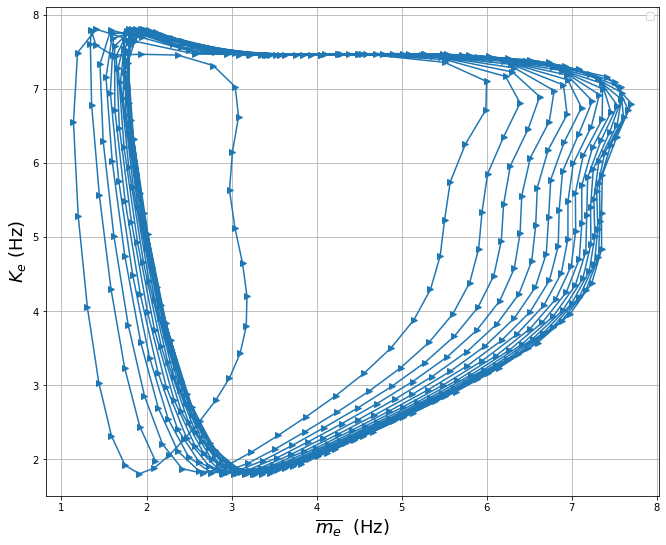

In [9]:
fig,ax=plt.subplots(figsize=(11, 9))

ax.plot(frE1_euler[39,1000:1500],frE1_euler[39,2000:2500],'->')

ax.set_ylabel("$K_e$ (Hz)",fontsize=18)
ax.grid(True)

ax.set_xlabel("$\\overline{m_e}$  (Hz)",fontsize=18)
ax.legend()



No handles with labels found to put in legend.


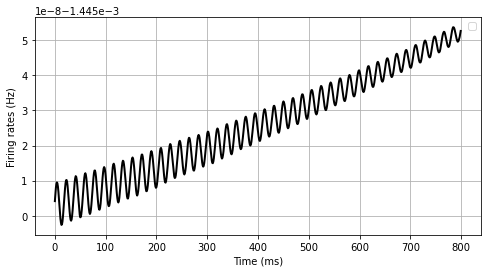

In [4]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(frE1_euler[19,3000:3800], 'k', lw=2,label="")

ax.set_xlabel("Time (ms)")
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)")
ax.legend()

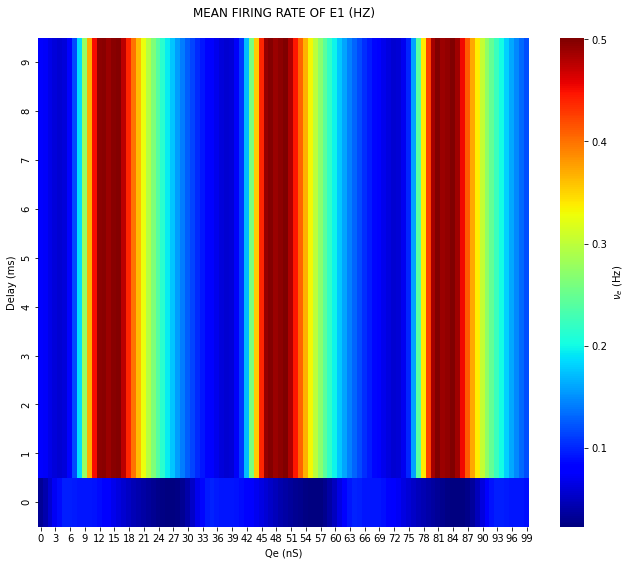

In [40]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE1_euler[39:49,3900:4000], cmap="jet",cbar_kws={'label': '$\\nu_e$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
#ax.set_xticks(np.linspace(0,22,10))
#ax.set_xticklabels(np.linspace(0,22,10))
#ax.set_yticks(np.linspace(0,50,5))
#ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

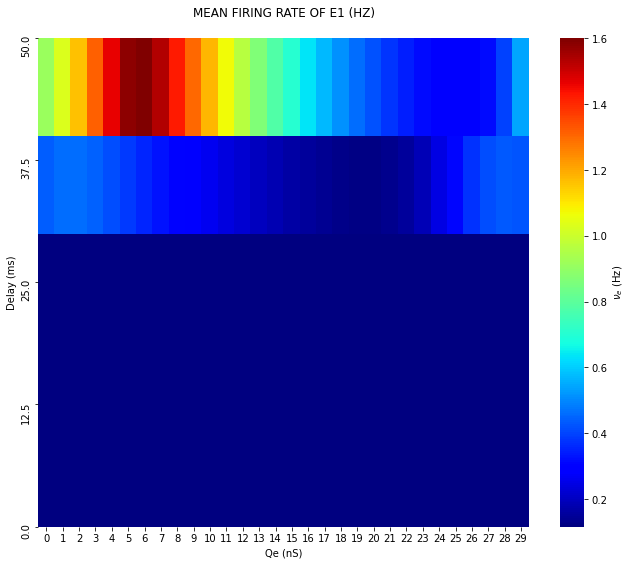

In [20]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE1_euler[:,625:655]*10, cmap="jet",cbar_kws={'label': '$\\nu_e$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
#ax.set_xticks(np.linspace(0,22,10))
#ax.set_xticklabels(np.linspace(0,22,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

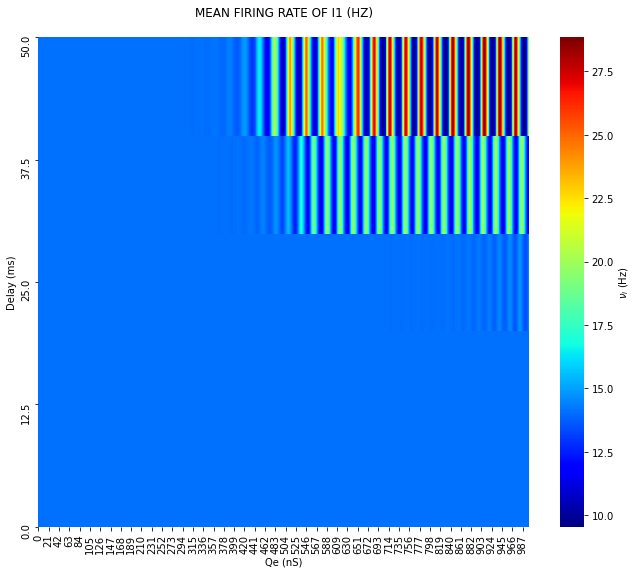

In [67]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI2_euler[:,0:1001], cmap="jet",cbar_kws={'label': '$\\nu_i$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
#ax.set_xticks(np.linspace(0,22,10))
#ax.set_xticklabels(np.linspace(0,22,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

In [151]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE1_euler*(12/5), cmap="jet",cbar_kws={'label': '$\\nu_e$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,30,10))
ax.set_xticklabels(np.linspace(0,30,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
#ax.invert_xaxis()
# title
title = 'Mean Firing Rate of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

array([0. , 0.1, 0.2, 0.3, 0.4])

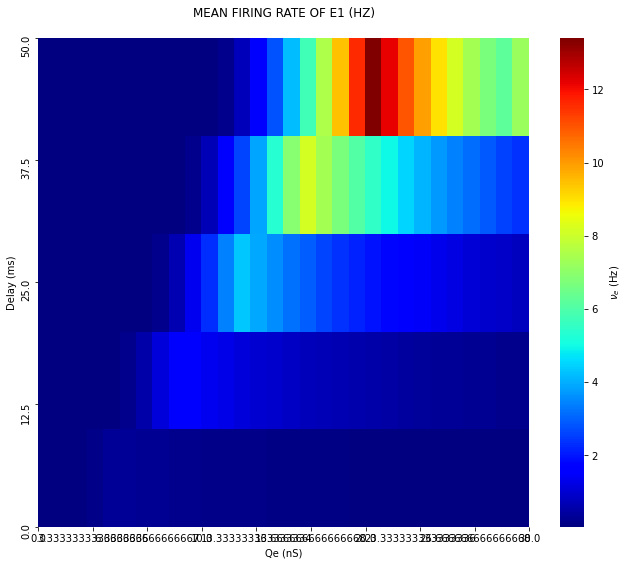

In [159]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE1_rk4, cmap="jet",cbar_kws={'label': '$\\nu_e$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,30,10))
ax.set_xticklabels(np.linspace(0,30,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
#ax.invert_xaxis()
# title
title = 'Mean Firing Rate of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

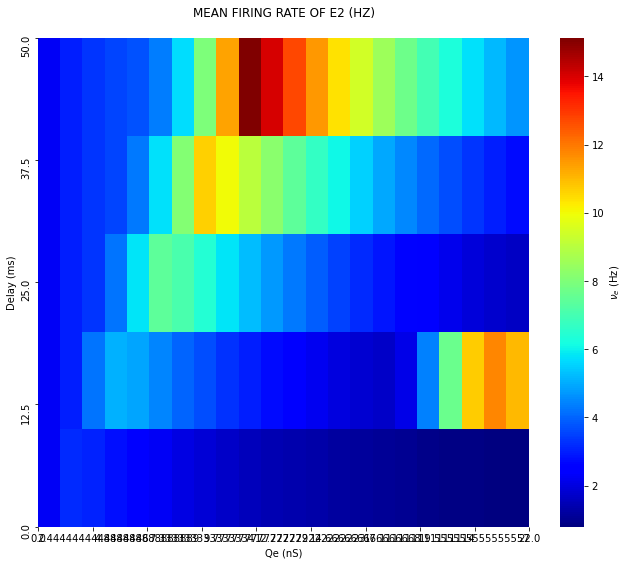

In [42]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE2_rk4, cmap="jet",cbar_kws={'label': '$\\nu_e$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,22,10))
ax.set_xticklabels(np.linspace(0,22,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of E2 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

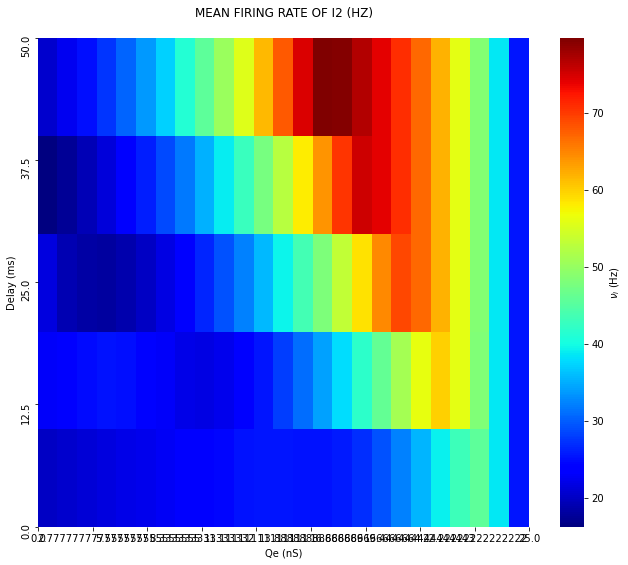

In [233]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI2_rk4, cmap="jet",cbar_kws={'label': '$\\nu_i$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,25,10))
ax.set_xticklabels(np.linspace(0,25,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I2 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

# Noise O-U 

In [ ]:
def Ornstein_U_list(xi_0,dt,tot_time,tau):
    
    for i in np.arange(0,tot_time,dt):
        xi_0+=-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
        
###   To integrate in the MF, it needs to be written as a function

def OU_func_list(t,O_U_list):
    return O_U_list[t]

def Ornstein_func(xi_0,dt,tau):
    
    return xi_0-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()

In [ ]:
np.random.seed(10)
import datetime ### To keep track of time, might be useful, little bit like a watch
x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.6 #ve2 exp
x0[2]=7.0 #vi1 exp 
x0[3]=7.0 #vi2 exp
x0[20]=x0[0]*1e-12 
x0[21]=x0[1]*1e-12 #w exp
print(x0)
time=0
t_trace2=[]
#T=0.005
#x_trace_aWITHTAU=[]
x_trace_RS_with_noise=[]
TF_trace_RS_with_noise=[]

drive=[]
params['tstep']=1e-4
params['T']=0.005


xi_exc=0 ## O_U process
xi_inh=0


print(x0)
time=0
    
for i in np.arange(0,2,params['tstep']):
    TF_inst= Euler_method_General(x0,params,time,MeanField_dN_dp_Hybrid_noise)
    
    xi_exc=Ornstein_func(xi_exc,params['tstep'],5e-4)
    xi_inh=Ornstein_func(xi_inh,params['tstep'],5e-4)

    params['ext_inp'][0]=2.0+10.5*xi_exc    
    params['ext_inp'][1]=2.0+10.5*xi_inh
    
    if (i%0.5==0):
        print('i = ', i, '\n')
        print('time : ', datetime.datetime.now(), ' \n \n')
    time+=params['tstep']
    t_trace2.append(time)
    
    x_trace_RS_with_noise.append(x0.copy())
    TF_trace_RS_with_noise.append(TF_inst.copy())
    drive.append(params['ext_inp'])
    

# Perturbation

### Draw distribution

1.0000000000000007e-08 1.1180339887219443e-05 0.5247965918467479 6.491887650492998e-06 0.6390968632923207 0.1490945045420307 4.613344479985466 0.40508183579432433


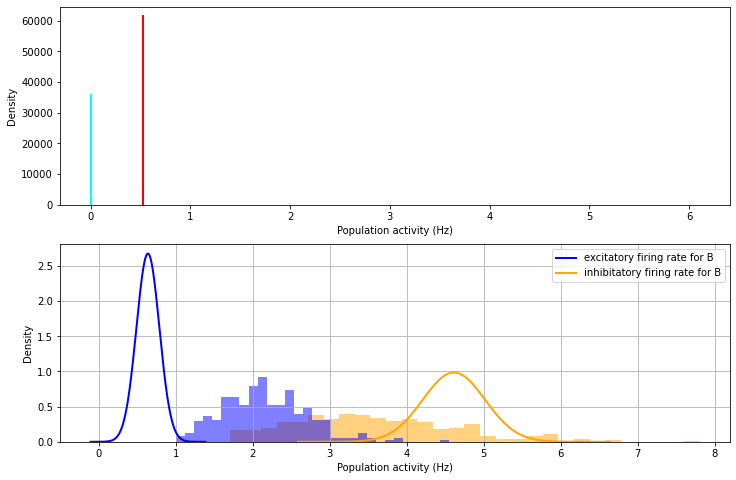

In [20]:
import scipy.stats
import cmath

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]
ST_popRateG3=popRateG3[int(len(popRateG3)/5)::] 
ST_popRateG4=popRateG4[int(len(popRateG4)/5)::]

axs[0].hist(ST_popRateG1, color='red',density= True, bins=30, alpha=0.5)
axs[0].hist(ST_popRateG2, color='cyan',density=True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG3, color='orange',density= True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG4, color='blue',density=True, bins=30, alpha=0.5)


mean_RS1=final_state[0]
std_RS1=np.sqrt(final_state[4])

mean_RS2=final_state[1]
std_RS2=np.sqrt(final_state[9])

mean_FS1=final_state[2]
std_FS1=np.sqrt(final_state[12])

mean_FS2=final_state[3]
std_FS2=np.sqrt(final_state[19])


print(mean_RS1,std_RS1,mean_FS1,std_FS1,mean_RS2,std_RS2,mean_FS2,std_FS2)

x_min_RS1=mean_RS1-5*std_RS1 #x_min_RS=mean_RS-5*std_RS
x_max_RS1=mean_RS1+5*std_RS1

x_min_RS2=mean_RS2-5*std_RS2 #x_min_RS=mean_RS-5*std_RS
x_max_RS2=mean_RS2+5*std_RS2

x_min_FS1=mean_FS1-5*std_FS1
x_max_FS1=mean_FS1+5*std_FS1

x_min_FS2=mean_FS2-5*std_FS2
x_max_FS2=mean_FS2+5*std_FS2

x_RS1 = np.linspace(x_min_RS1, x_max_RS1, 1000)
x_FS1 = np.linspace(x_min_FS1, x_max_FS1, 1000)
x_RS2 = np.linspace(x_min_RS2, x_max_RS2, 1000)
x_FS2 = np.linspace(x_min_FS2, x_max_FS2, 1000)


Distrib_RS1=[]
Distrib_FS1=[]
Distrib_RS2=[]
Distrib_FS2=[]


for i in range(len(x_RS1)):
    Distrib_RS1.append(gaussian(x_RS1[i],mean_RS1,std_RS1))
    Distrib_RS2.append(gaussian(x_RS2[i],mean_RS2,std_RS2))
    Distrib_FS1.append(gaussian(x_FS1[i],mean_FS1,std_FS1))
    Distrib_FS2.append(gaussian(x_FS2[i],mean_FS2,std_FS2))


axs[0].plot(x_RS1,Distrib_RS1,color='cyan',lw=2,label='excitatory firing rate for A')
axs[1].plot(x_RS2,Distrib_RS2,color='blue',lw=2,label='excitatory firing rate for B')
axs[0].plot(x_FS1,Distrib_FS1,color='red',lw=2, label='inhibitatory firing rate for A')
axs[1].plot(x_FS2,Distrib_FS2,color='orange',lw=2, label='inhibitatory firing rate for B')
                             
axs[0].set_xlabel("Population activity (Hz)")
axs[0].set_ylabel("Density")
axs[1].set_xlabel("Population activity (Hz)")
axs[1].set_ylabel("Density")
plt.grid(True)
#plt.ylabel("Density")
plt.legend()
plt.show()

In [41]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])